In [1]:
# KT Noted: Using CUBEMS environment
# KT Noted: ChatGPT o3-mini-high (16 Feb 2025)

In [2]:
import time
import pandas as pd
import numpy as np
from scipy import stats

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [4]:
import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
# Set a global random seed
SEED = 42
np.random.seed(SEED)

In [6]:
# -------------------------------
# 1. Data Preparation & Splitting
# -------------------------------

In [7]:
# Load the CSV file
file_path = r"C:\Users\kornn\Dropbox\00_EnergyModel_Weather\Dataset\Training_Combinded\train_df.csv"  
train_df = pd.read_csv(file_path)
train_df.head()

,Date,Total_kWh,Hour_of_Day,Day_of_week,Holiday,Weekend,Weekday,Working_Hour,Noon,Temperature,Dew Point,Humidity,Pressure,Solar
0,2018-07-01 00:00:00,176.261667,0,6,0,1,0,0,0,25.0,24.2,95,1006.43,0
1,2018-07-01 01:00:00,177.300000,1,6,0,1,0,0,0,25.5,24.8,96,1006.43,0
2,2018-07-01 02:00:00,177.048833,2,6,0,1,0,0,0,25.8,24.9,95,1005.76,0
3,2018-07-01 03:00:00,175.129167,3,6,0,1,0,0,0,25.7,24.7,94,1005.08,0
4,2018-07-01 04:00:00,183.175000,4,6,0,1,0,0,0,26.3,24.6,90,1005.42,0


In [8]:
train_df['Date'] = pd.to_datetime(train_df['Date']) # Make Date column is in datetime format

In [9]:
# Train and Test Split 
train_set = (train_df['Date'] >= '2018-07-01 00:00:00') & (train_df['Date'] <= '2019-06-30 23:00:00')
test_set = (train_df['Date'] >= '2019-07-01 00:00:00') & (train_df['Date'] <= '2019-08-31 23:00:00')

In [10]:
# Create the training and test DataFrames
train_data = train_df.loc[train_set].copy()
test_data = train_df.loc[test_set].copy()

In [11]:
# -------------------------------
# 2. Set Features and Target
# -------------------------------

In [12]:
target_col = 'Total_kWh' # Set the target variable
feature_cols = [col for col in train_df.columns if col not in ['Date', target_col]] # Set the features

In [13]:
X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

In [14]:
# -------------------------------
# 3. LightGBM Tuning with OPTUNA
# -------------------------------

In [15]:
def search(trial):
    param = {
        'objective': 'regression', # Default 'regression' is L2, please choose 'regression_l1' for L1
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': SEED,      # set the seed in LightGBM for reproducibility
        
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth' : trial.suggest_int('max_depth', 1, 16),
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'min_gain_to_split': trial.suggest_loguniform('min_gain_to_split', 1e-8, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0)        
    }

    # Create LightGBM datasets for training and validation
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    # Train the model with early stopping
    gbm = lgb.train(
        param,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=0)]
    )
    
    # Predict on the test set and calculate RMSE
    preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

In [16]:
# Hide warnings and OPTUNA logging messages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

optuna.logging.set_verbosity(optuna.logging.ERROR)

In [17]:
# Start timing before training
start_time = time.time()

In [18]:
# Run the OPTUNA optimization
study = optuna.create_study(direction='minimize', 
                            sampler=optuna.samplers.TPESampler(seed=SEED)) # set the seed in OPTUNA for reproducibility
                            # pruner=optuna.pruners.MedianPruner()         # Prune bad trials
study.optimize(search, n_trials=200)  


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[152]	training's rmse: 77.2437	valid_1's rmse: 85.4359
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[572]	training's rmse: 63.0241	valid_1's rmse: 71.3372
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[159]	training's rmse: 43.3676	valid_1's rmse: 63.5881
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[479]	training's rmse: 51.2145	valid_1's rmse: 63.1303
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[972]	training's rmse: 65.0344	valid_1's rmse: 70.9116
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[344]	training's rmse: 79.2521	valid_1's rmse: 96.6172
Training until validation sco

In [19]:
# End timing after training
end_time = time.time()
training_time = end_time - start_time # Calculate training duration
print(f"Model training time: {training_time/60:.2f} minutes") 

Model training time: 3.71 minutes


In [20]:
best_params = study.best_params.copy()

print("Best hyperparameters:")
for key, value in best_params.items():
    if isinstance(value, float):
        print(f"{key}: {value:.3f}")
    else:
        print(f"{key}: {value}")

Best hyperparameters:
feature_fraction: 0.869
bagging_fraction: 0.945
bagging_freq: 3
learning_rate: 0.013
num_leaves: 39
max_depth: 16
n_estimators: 776
min_data_in_leaf: 44
min_gain_to_split: 0.000
lambda_l1: 0.000
lambda_l2: 0.000


In [21]:
# -------------------------------
# Retrain the Model with Best Hyperparameters and Evaluate
# -------------------------------

In [22]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)
best_model = lgb.train(
    best_params,
    lgb_train, 
    valid_sets=[lgb_test],
    callbacks=[lgb.early_stopping(stopping_rounds=50),
               lgb.log_evaluation(period=100)]  # prints evaluation every 100 rounds    
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 10797.4
[200]	valid_0's l2: 4882.09
[300]	valid_0's l2: 3899.61
[400]	valid_0's l2: 3657.41
[500]	valid_0's l2: 3582.7
[600]	valid_0's l2: 3548.06
Early stopping, best iteration is:
[633]	valid_0's l2: 3532.02


In [23]:
# ----------------------------------------
# Evaluate the Model (Train and Test Set)
# ----------------------------------------

In [24]:
# Calculate evaluation metrics: RMSE, CV(RMSE), NMBE, and R2
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    cv_rmse = (rmse / np.mean(y_true)) * 100
    nmbe = (np.mean(y_pred - y_true) / np.mean(y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return {'rmse': rmse, 'cv_rmse': cv_rmse, 'nmbe': nmbe, 'r2': r2}

In [25]:
# Predict on the training set using the best_model 
y_pred_train = best_model.predict(X_train, num_iteration=best_model.best_iteration)
train_metrics = evaluate_model(y_train, y_pred_train)

In [26]:
print("Evaluation Metrics on Train Set (Optuna):")
print("RMSE: {:.3f}".format(train_metrics['rmse']))
print("CV(RMSE): {:.2f}%".format(train_metrics['cv_rmse']), "| IPMVP < 20% | ASHRAE & FEMP < 30%")
print("NMBE: {:.2f}%".format(train_metrics['nmbe']), "| IPMVP < 5% | ASHRAE & FEMP < 10%")
print("R2 Score: {:.3f}".format(train_metrics['r2']), "| IPMVP & ASHRAE > 0.75 | FEMP = NA")

Evaluation Metrics on Train Set (Optuna):
RMSE: 46.618
CV(RMSE): 18.00% | IPMVP < 20% | ASHRAE & FEMP < 30%
NMBE: 0.00% | IPMVP < 5% | ASHRAE & FEMP < 10%
R2 Score: 0.945 | IPMVP & ASHRAE > 0.75 | FEMP = NA


In [27]:
# Evaluate the final model on the test set
y_pred_test = best_model.predict(X_test, num_iteration=best_model.best_iteration)
test_metrics = evaluate_model(y_test, y_pred_test)

In [28]:
print("\nEvaluation Metrics on Test Set (OPTUNA):")
print("RMSE: {:.3f}".format(test_metrics['rmse']))
print("CV(RMSE): {:.2f}%".format(test_metrics['cv_rmse']), "| IPMVP < 20% | ASHRAE & FEMP < 30%")
print("NMBE: {:.2f}%".format(test_metrics['nmbe']), "| IPMVP < 5% | ASHRAE & FEMP < 10%")
print("R2 Score: {:.3f}".format(test_metrics['r2']), "| IPMVP & ASHRAE > 0.75 | FEMP = NA")


Evaluation Metrics on Test Set (OPTUNA):
RMSE: 59.431
CV(RMSE): 20.75% | IPMVP < 20% | ASHRAE & FEMP < 30%
NMBE: -1.24% | IPMVP < 5% | ASHRAE & FEMP < 10%
R2 Score: 0.936 | IPMVP & ASHRAE > 0.75 | FEMP = NA


In [29]:
# -------------------------------
# Residual Plots
# -------------------------------

In [42]:
# Calculate final residuals
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

# Determine Min-Max for common y-axis limits
residual_min = min(residuals_train.min(), residuals_test.min())
residual_max = max(residuals_train.max(), residuals_test.max())

# Adding column for residuals in train and test data
train_data["Residuals"] = residuals_train
test_data["Residuals"] = residuals_test

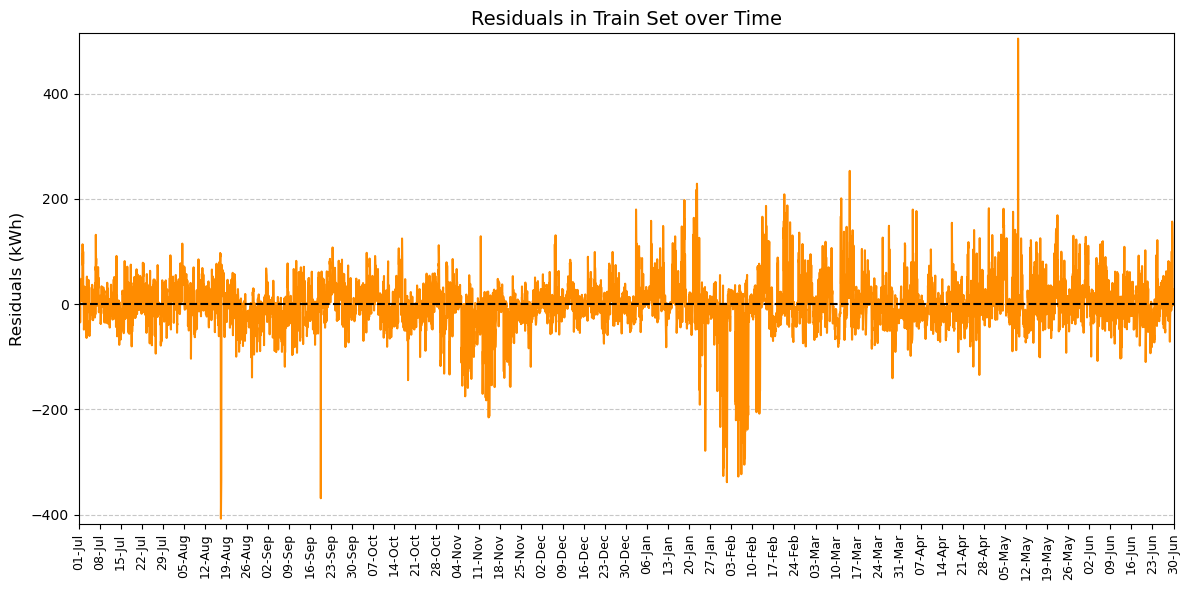

In [112]:
# Plot the Train residuals
train_start = pd.Timestamp("2018-07-01")
train_end = pd.Timestamp("2019-06-30")

plt.figure(figsize=(12, 6))

plt.plot(train_data["Date"], train_data["Residuals"], label="Train Residuals", linestyle="-", color="darkorange")
plt.axhline(y=0, color="black", linestyle="--")

plt.ylim(residual_min-10, residual_max+10)
plt.xlim(pd.Timestamp(train_start), pd.Timestamp(train_end))

plt.xlabel("")
plt.ylabel("Residuals (kWh)", fontsize=12)
plt.title("Residuals in Train Set over Time", fontsize=14)

month_ticks = pd.date_range(start=train_start, end=train_end , freq="W")
plt.xticks(month_ticks, month_ticks.strftime("%d-%b"), rotation=90, fontsize=9)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

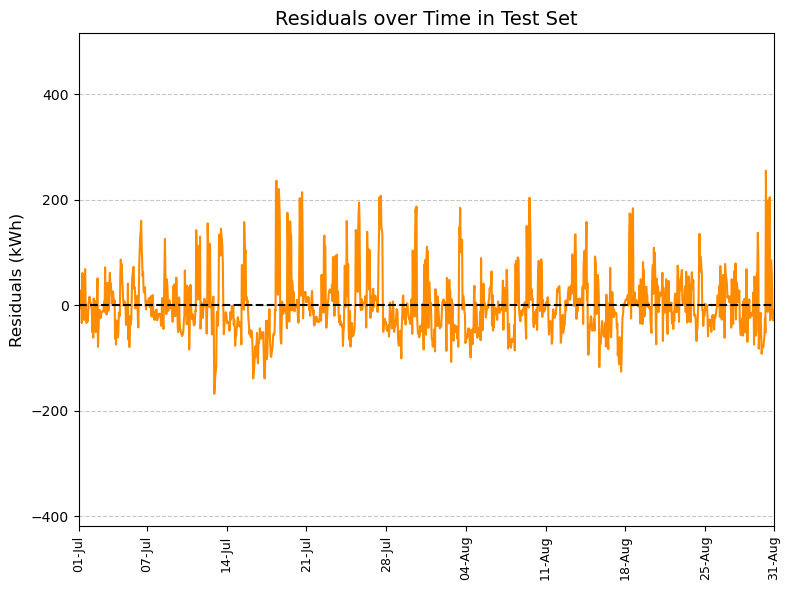

In [ ]:
# Plot the Test residuals
test_start = pd.Timestamp("2019-07-01")
test_end = pd.Timestamp("2019-08-31")

# Plot the Test residuals
plt.figure(figsize=(8, 6))
plt.plot(test_data["Date"], test_data["Residuals"], label="Test Residuals", linestyle="-", color="darkorange")
plt.axhline(y=0, color="black", linestyle="--")

plt.ylim(residual_min-10, residual_max+10)
plt.xlim(pd.Timestamp(test_start), pd.Timestamp(test_end))

plt.xlabel("")
plt.ylabel("Residuals (kWh)", fontsize=12)
plt.title("Residuals over Time in Test Set", fontsize=14)

month_ticks = pd.date_range(start=test_start, end=test_end, freq="W")
month_ticks = [test_start] + list(month_ticks) + [test_end]   # Add start and end date manually to the ticks list
plt.xticks(month_ticks, [tick.strftime("%d-%b") for tick in month_ticks], rotation=90, fontsize=9)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

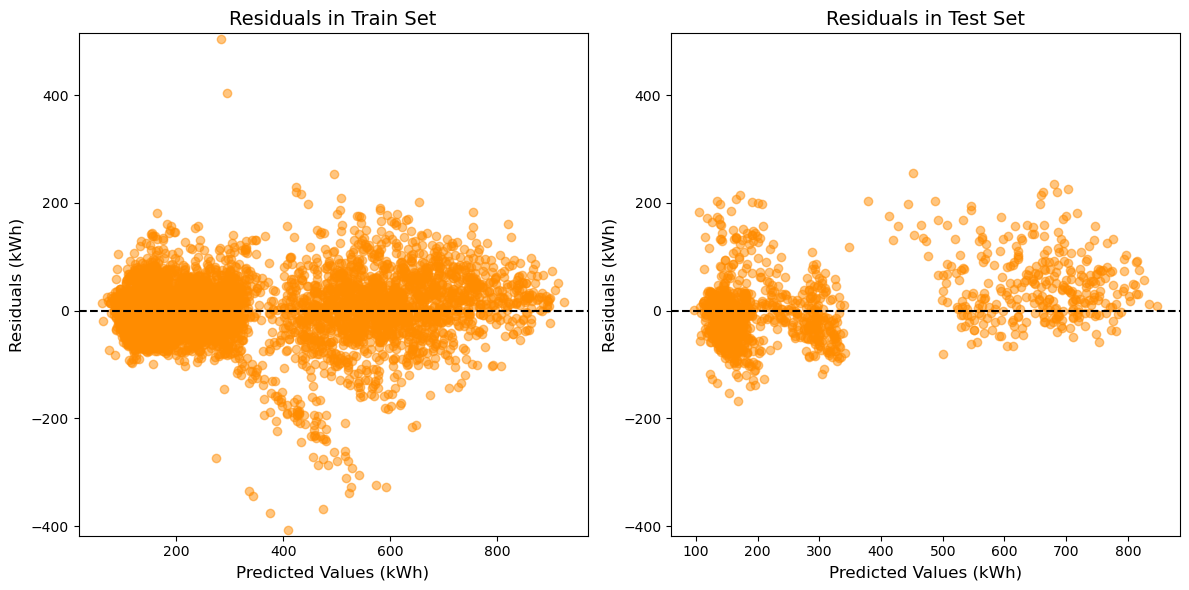

In [60]:
# Plot residuals
plt.figure(figsize=(12, 6))

# Train residuals
plt.subplot(1, 2, 1)
plt.scatter(y_pred_train, residuals_train, color='darkorange', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(residual_min-10, residual_max+10)
plt.title('Residuals in Train Set', fontsize=14)
plt.xlabel('Predicted Values (kWh)', fontsize=12)
plt.ylabel('Residuals (kWh)', fontsize=12)

# Test residuals
plt.subplot(1, 2, 2)
plt.scatter(y_pred_test, residuals_test, color='darkorange', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')

plt.ylim(residual_min-10, residual_max+10)
plt.title('Residuals in Test Set', fontsize=14)
plt.xlabel('Predicted Values (kWh)', fontsize=12)
plt.ylabel('Residuals (kWh)', fontsize=12)

plt.tight_layout()
plt.show()

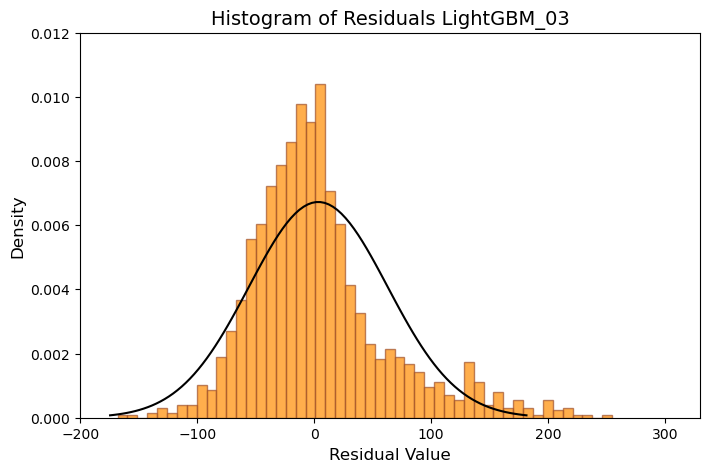

In [32]:
# Histogram of Residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals_test, bins=50, density=True, alpha=0.7, color="darkorange", edgecolor="sienna")

# Calculate mean and standard deviation
mu, sigma = np.mean(residuals_test), np.std(residuals_test)

# Plot normal distribution curve
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color="black", linewidth=1.5)

# Add labels and title
plt.xlabel("Residual Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Histogram of Residuals LightGBM_03", fontsize=14)

plt.ylim(0, 0.012) # Set y-axis limit
plt.xlim(-200, 330) # Set x-axis limit

# Display plot
plt.show()

In [33]:
# Residual statistics
residual_stats = {
    "Mean": np.mean(residuals_test),
    "Variance": np.var(residuals_test),
    "Skewness": stats.skew(residuals_test),     # skewness / asymmetry of the distribution
    "Kurtosis": stats.kurtosis(residuals_test)  # tailedness of the distribution
}
# Display residual statistics in a DataFrame
residual_df_summary = pd.DataFrame(residual_stats, index=["Residuals"])
print(residual_df_summary.round(3))

            Mean  Variance  Skewness  Kurtosis
Residuals  3.553  3519.397     1.071     1.729


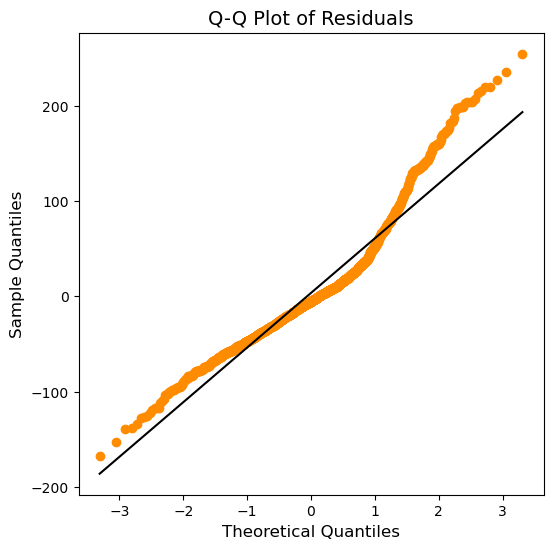

In [34]:
# Q-Q Plot for Normality Check
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)  # Add subplot to get axis object

# Generate Q-Q plot
stats.probplot(residuals_test, dist="norm", plot=ax)

# Customize colors
ax.get_lines()[0].set_color('darkorange')  # Data points
ax.get_lines()[1].set_color('black')       # 45-degree line

# Add titles and labels
ax.set_title("Q-Q Plot of Residuals", fontsize=14)
ax.set_xlabel("Theoretical Quantiles", fontsize=12)
ax.set_ylabel("Sample Quantiles", fontsize=12)

# Display plot
plt.show()

In [35]:
# -------------------------------
# kWh Plots
# -------------------------------

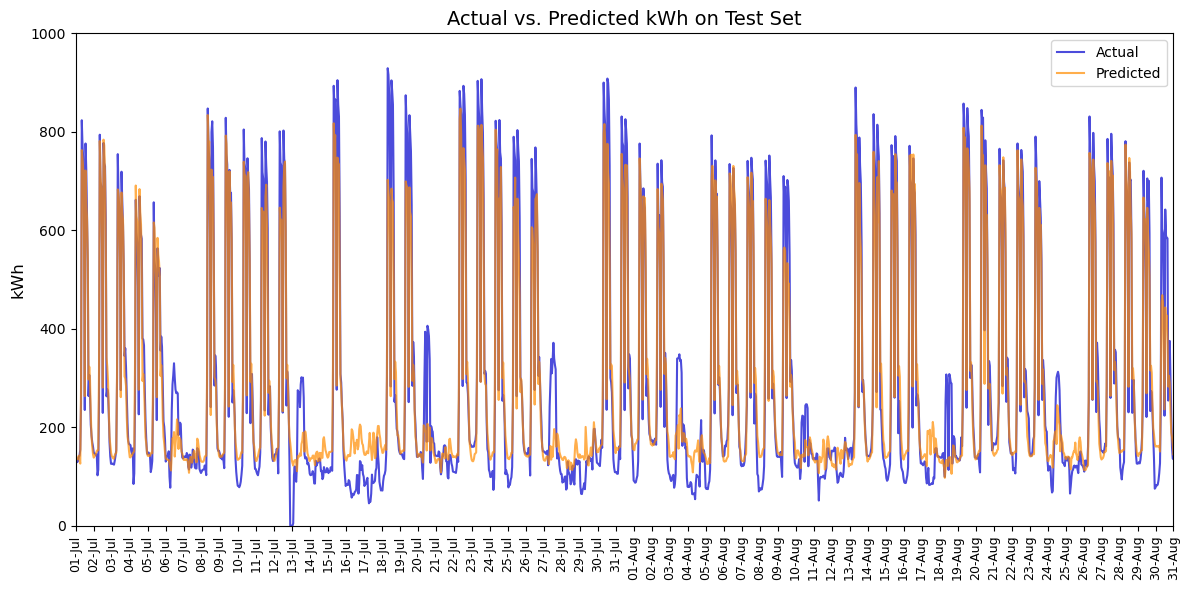

In [109]:
# (a) Actual vs. Predicted over time
test_start = pd.Timestamp("2019-07-01")
test_end = pd.Timestamp("2019-08-31")

plt.figure(figsize=(12,6))
plt.plot(test_data['Date'], y_test, label='Actual', linestyle='-', color='mediumblue', alpha=0.7)
plt.plot(test_data['Date'], y_pred_test, label='Predicted', linestyle='-', color='darkorange', alpha=0.7)
plt.xlabel('')
plt.ylabel('kWh', fontsize=12)
plt.ylim(0, 1000)
plt.title('Actual vs. Predicted kWh on Test Set', fontsize=14)
plt.legend()

month_ticks = pd.date_range(start=test_start, end=test_end, freq='D')
plt.xticks(month_ticks, month_ticks.strftime('%d-%b'), rotation=90, fontsize=9)

plt.xlim(pd.Timestamp(test_start), pd.Timestamp(test_end))

plt.tight_layout()
plt.show()

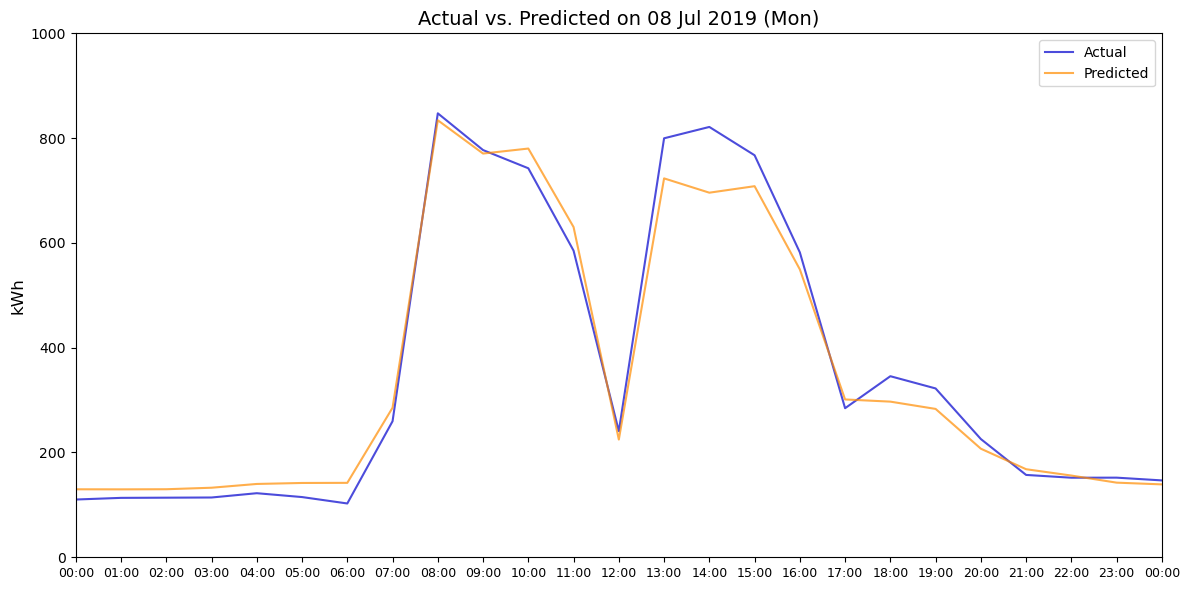

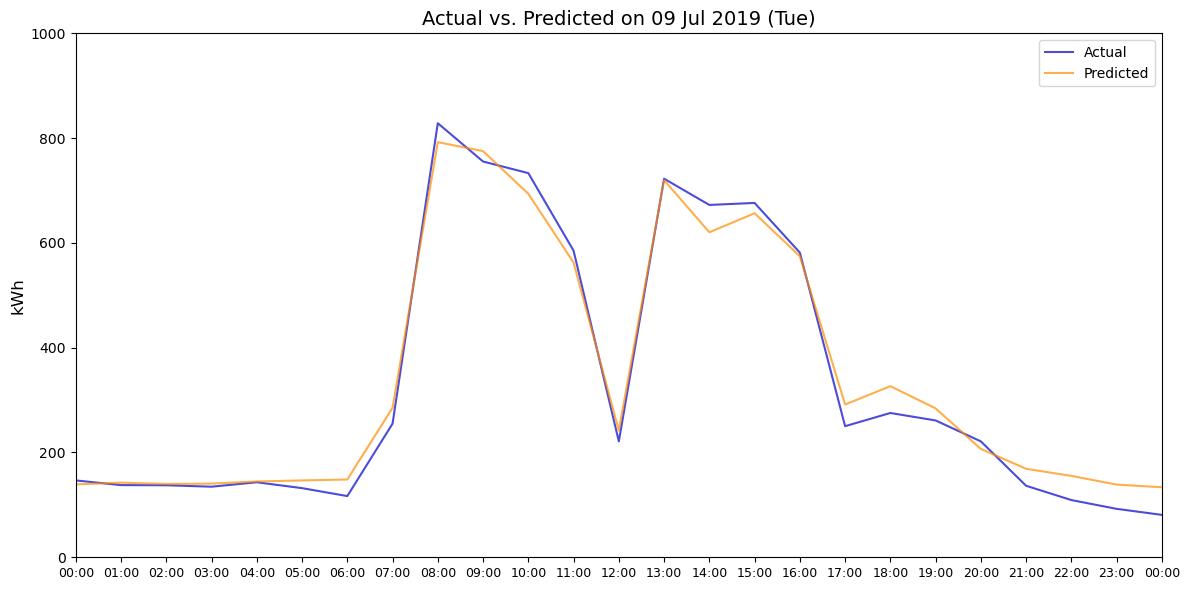

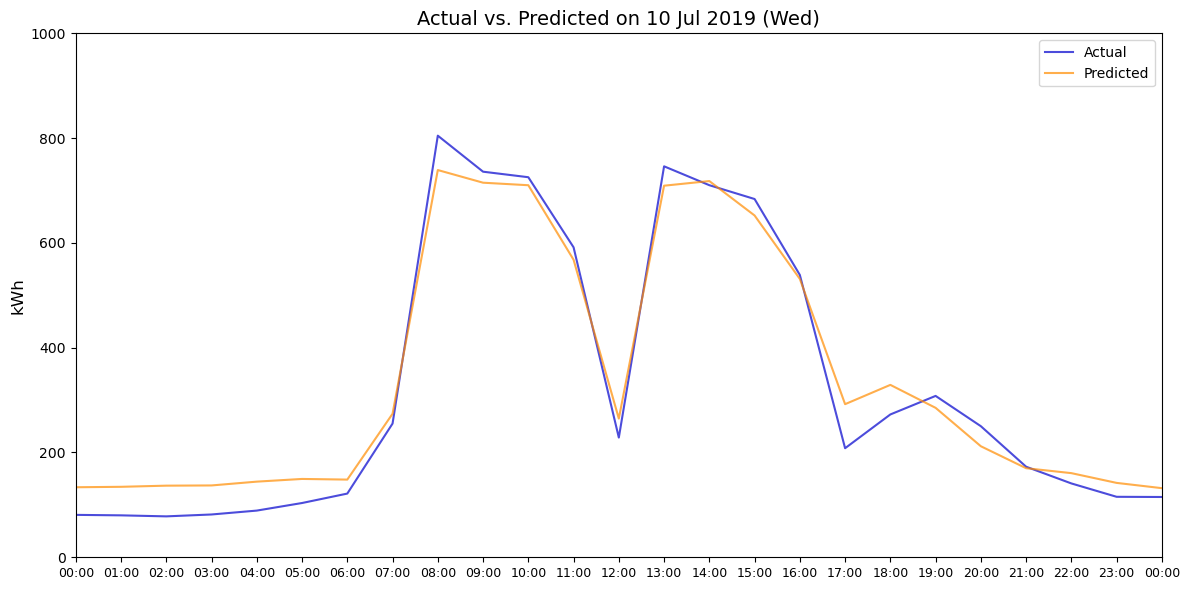

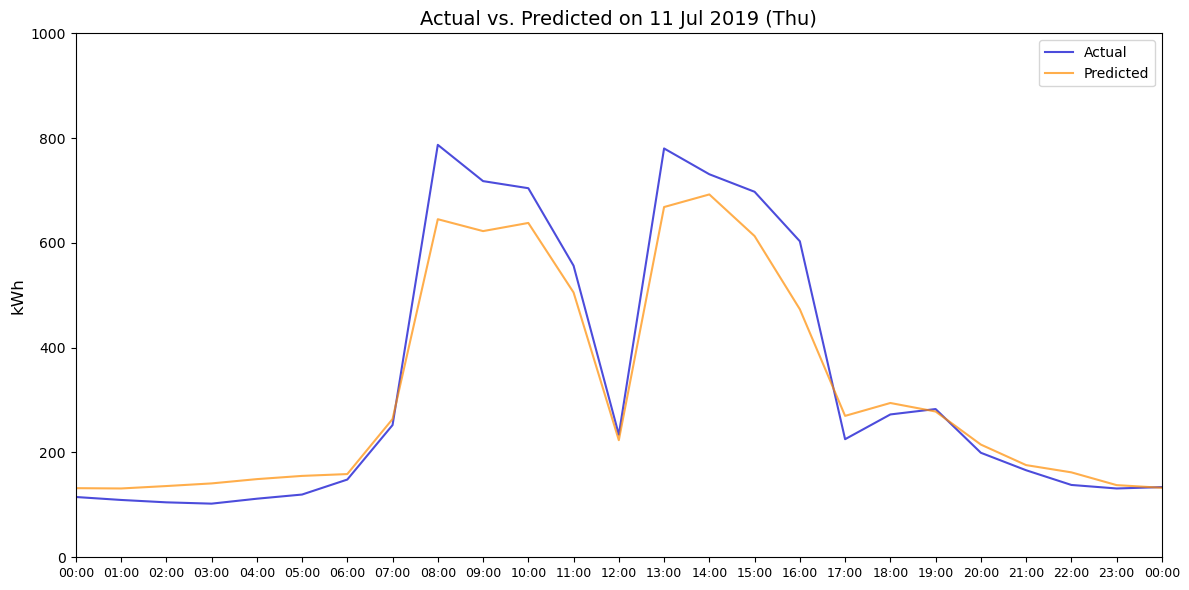

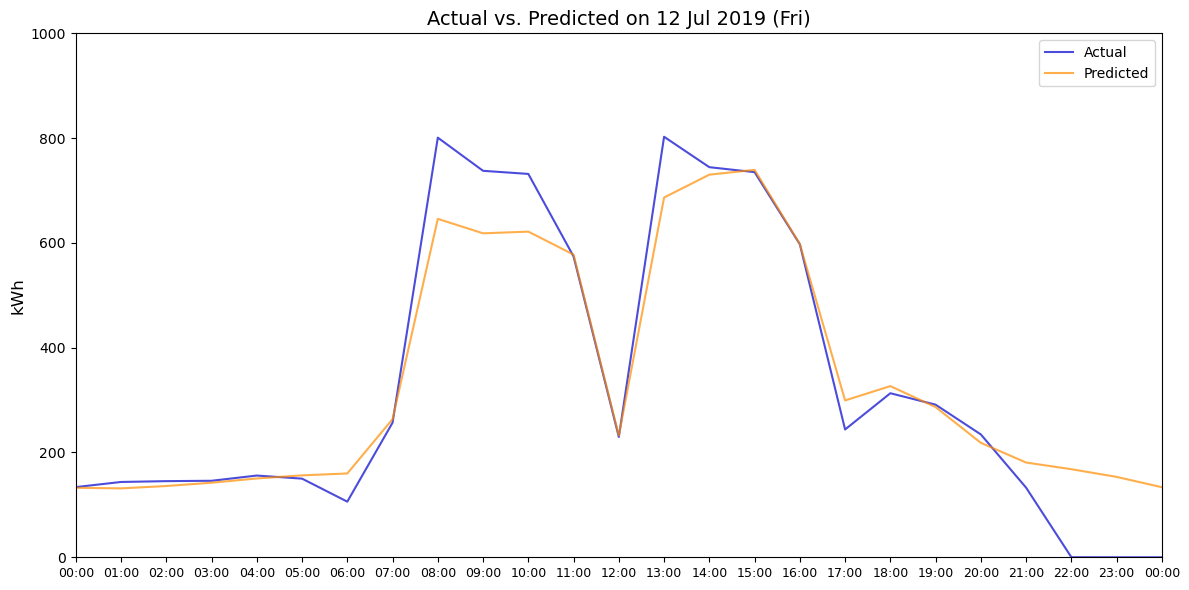

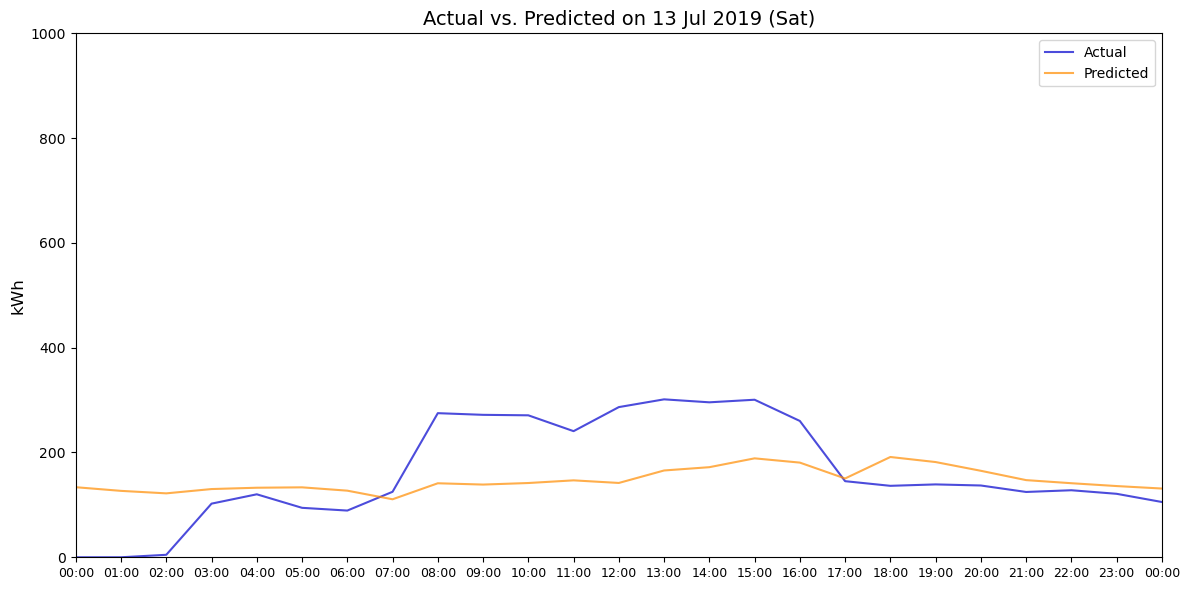

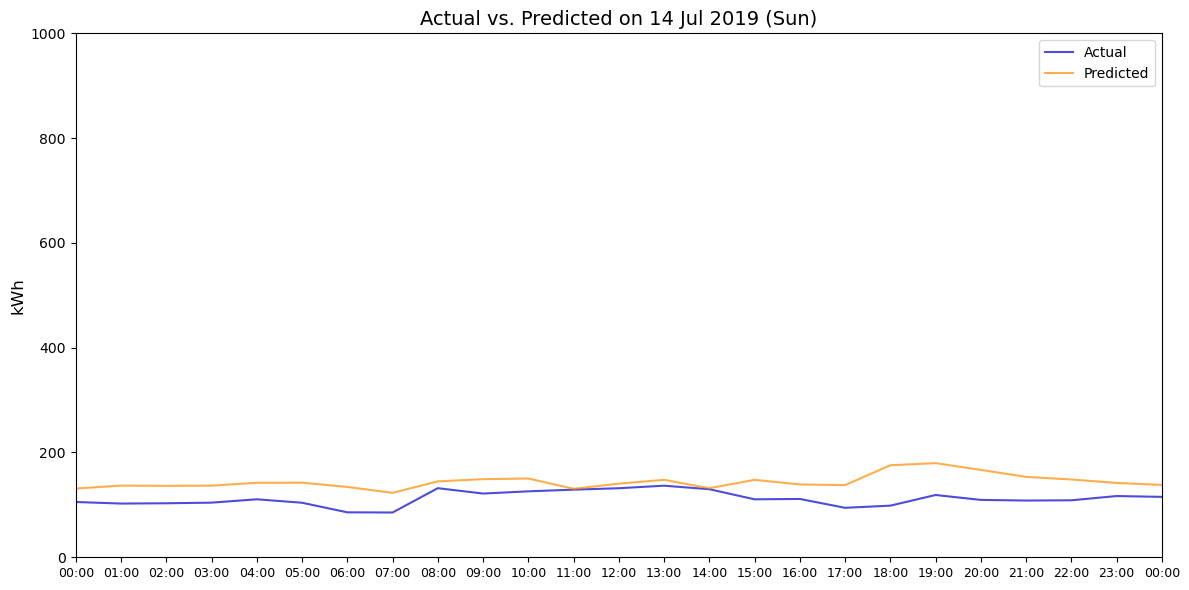

In [37]:
# Define the specific dates you want to plot
selected_days = ['2019-07-08', '2019-07-09', '2019-07-10', '2019-07-11', '2019-07-12', '2019-07-13', '2019-07-14']

# Convert to datetime for accurate filtering
selected_days = pd.to_datetime(selected_days)

# Loop through each selected day and plot
for day in selected_days:
    # Filter data for the current day and include 00:00 of the next day
    mask = (test_data['Date'] >= day) & (test_data['Date'] <= day + pd.Timedelta(days=1))
    filtered_data = test_data[mask]
    filtered_y_test = y_test[mask]
    filtered_y_pred = y_pred_test[mask]

    # Plotting Actual vs. Predicted for the current day
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['Date'], filtered_y_test, label='Actual', linestyle='-', color='mediumblue', alpha=0.7)
    plt.plot(filtered_data['Date'], filtered_y_pred, label='Predicted', linestyle='-', color='darkorange', alpha=0.7)

    plt.xlabel('')
    plt.ylabel('kWh', fontsize=12)
    plt.ylim(0, 1000)
    #plt.title(f'Actual vs. Predicted on {day.strftime("%d-%b-%Y")}', fontsize=14)
    plt.title(f'Actual vs. Predicted on {day.strftime("%d %b %Y (%a)")}', fontsize=14)

    plt.legend()

    # Set x-axis ticks to every hour, extending to 00:00 of the next day
    hour_ticks = pd.date_range(start=day, end=day + pd.Timedelta(days=1), freq='h')
    plt.xticks(hour_ticks, hour_ticks.strftime('%H:%M'), fontsize=9)

    # Adjust x-axis limits to extend until 00:00 of the next day
    plt.xlim(day, day + pd.Timedelta(days=1))

    plt.tight_layout()
    plt.show()

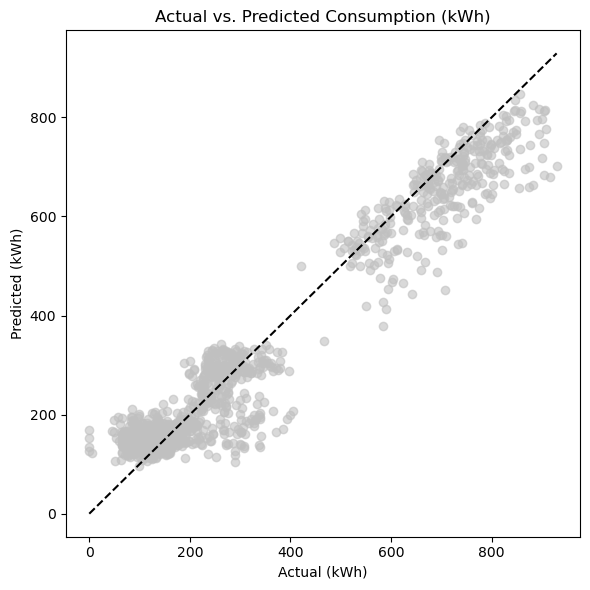

In [38]:
# Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, color='silver', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--')  # 45-degree line
plt.xlabel('Actual (kWh)')
plt.ylabel('Predicted (kWh)')
plt.title('Actual vs. Predicted Consumption (kWh)')
plt.tight_layout()
plt.show()

In [ ]:
####################### The End #######################